In [1]:
import torch
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import ImageFile
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
train_data_dir = r'C://Users//AniRoy//Desktop//ML Project1//Mini_Project-master//covid detection//covid//train6'
valid_data_dir = r'C://Users//AniRoy//Desktop//ML Project1//Mini_Project-master//covid detection//covid//validation6'
test_data_dir = r'C://Users//AniRoy//Desktop//ML Project1//Mini_Project-master//covid detection//covid//test6'

In [3]:
# num_class = 2
# image_dim = 224
batch_size = 8

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.RandomRotation(10),                                          
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=0.485,
                                                                std=0.229)])

valid_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485 ,std= 0.229)])

test_data_transform = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485,
                                                                std= 0.229)])

train_data = datasets.ImageFolder(train_data_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_data_dir, transform=valid_data_transform)
test_data = datasets.ImageFolder(test_data_dir, transform=test_data_transform)
train_data_load = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_data_load = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_data_load = DataLoader(test_data,batch_size=batch_size, shuffle = True)

In [5]:
use_cuda = torch.cuda.is_available()

In [6]:
len(valid_data_load)

25

In [7]:
loaders_transfer = {'train': train_data_load, 'valid': valid_data_load, 'test': test_data_load}

In [8]:
model_transfer = models.resnet18(pretrained=True)
model_transfer.out = nn.Linear(2048, 2)

if use_cuda:
    model_transfer = model_transfer.cuda() 

In [9]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

In [10]:
tl,vl,ta=[],[],[]
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        correct=0
        total=0

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            out = model(data)
            
            loss = criterion(out, target)
            
            loss.backward()
            optimizer.step()
            train_loss += ((1/(batch_idx + 1)) * (loss.data - train_loss))
            
            _, predicted = out.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            out = model(data)
            
            loss = criterion(out, target)
            valid_loss += ((1/(batch_idx + 1)) * (loss.data - valid_loss))
            
        ta.append(100. * correct/total) 
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        tl.append(train_loss)
        vl.append(valid_loss)
        
        #save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Valid loss decrease to  ({:.5f} -> {:.5f}). Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
   
    # return trained model
    return model

In [11]:
n_epochs = 45
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.43123 	Validation Loss: 0.43990
Valid loss decrease to  (inf -> 0.43990). Saving model ...
Epoch: 2 	Training Loss: 0.42718 	Validation Loss: 0.31330
Valid loss decrease to  (0.43990 -> 0.31330). Saving model ...
Epoch: 3 	Training Loss: 0.34155 	Validation Loss: 0.25245
Valid loss decrease to  (0.31330 -> 0.25245). Saving model ...
Epoch: 4 	Training Loss: 0.40433 	Validation Loss: 0.35647
Epoch: 5 	Training Loss: 0.27897 	Validation Loss: 0.66477
Epoch: 6 	Training Loss: 0.28316 	Validation Loss: 0.21470
Valid loss decrease to  (0.25245 -> 0.21470). Saving model ...
Epoch: 7 	Training Loss: 0.27980 	Validation Loss: 0.26040
Epoch: 8 	Training Loss: 0.31700 	Validation Loss: 0.34952
Epoch: 9 	Training Loss: 0.31627 	Validation Loss: 0.25830
Epoch: 10 	Training Loss: 0.29451 	Validation Loss: 0.44893
Epoch: 11 	Training Loss: 0.28514 	Validation Loss: 0.21968
Epoch: 12 	Training Loss: 0.28421 	Validation Loss: 0.23498
Epoch: 13 	Training Loss: 0.33980 	Valida

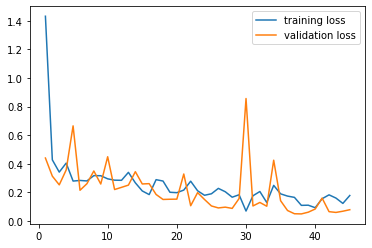

In [12]:
tl1=[]
vl1=[]
a=[]
for i in tl:
    tl1.append(float(i))
for i in vl:
    vl1.append(float(i))
for i in range(1,46):
    a.append(i)
plt.plot(a,tl1,label='training loss')
plt.plot(a,vl1,label='validation loss')
plt.legend()

92.33333333333333

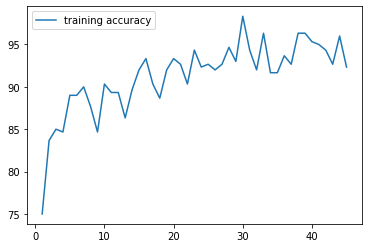

In [13]:
ta1=[]
for i in ta:
    ta1.append(float(i))
plt.plot(a,ta1,label='training accuracy')
plt.legend()
ta1[-1]

In [14]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [15]:
testa,testl=[],[]
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target) 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
        print('Test Loss: {:.6f}\n'.format(test_loss))
        testl.append(float(test_loss))

        print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
            100. * correct / total, correct, total))
        testa.append(100. * correct / total)
        print('')

In [16]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.036589


Test Accuracy: 100% ( 8/ 8)

Test Loss: 0.254093


Test Accuracy: 93% (15/16)

Test Loss: 0.201309


Test Accuracy: 91% (22/24)

Test Loss: 0.154684


Test Accuracy: 93% (30/32)

Test Loss: 0.124281


Test Accuracy: 95% (38/40)

Test Loss: 0.106129


Test Accuracy: 95% (46/48)

Test Loss: 0.093608


Test Accuracy: 96% (54/56)

Test Loss: 0.093293


Test Accuracy: 96% (62/64)

Test Loss: 0.086448


Test Accuracy: 97% (70/72)

Test Loss: 0.090792


Test Accuracy: 97% (78/80)

Test Loss: 0.085128


Test Accuracy: 97% (86/88)

Test Loss: 0.114536


Test Accuracy: 96% (93/96)

Test Loss: 0.106520


Test Accuracy: 97% (101/104)

Test Loss: 0.103180


Test Accuracy: 97% (109/112)

Test Loss: 0.105635


Test Accuracy: 96% (116/120)

Test Loss: 0.106664


Test Accuracy: 96% (123/128)

Test Loss: 0.100566


Test Accuracy: 96% (131/136)

Test Loss: 0.109384


Test Accuracy: 95% (138/144)

Test Loss: 0.104339


Test Accuracy: 96% (146/152)

Test Loss: 0.100076


Test Accuracy

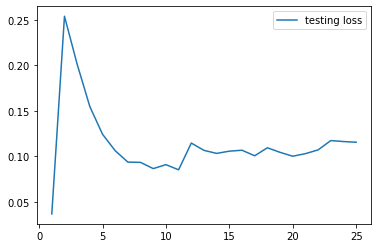

In [17]:
testl1=[]
a=[]
for i in testl:
    testl1.append(float(i))
for i in range(len(testl1)):
    a.append(i+1)
plt.plot(a,testl1,label='testing loss')
plt.legend()

95.0


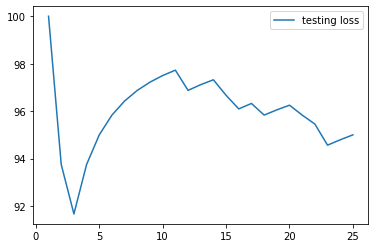

In [19]:
testa1=[]
for i in testa:
    testa1.append(float(i))
print(testa1[-1])
plt.plot(a,testa1,label='testing accuracy')
plt.legend()